# Neural Network Classification with PyTorch

# Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples

n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [ ]:
# make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X0": X[:, 0],
                        "X1": X[:, 1],
                        "label": y})
circles.head(10)

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


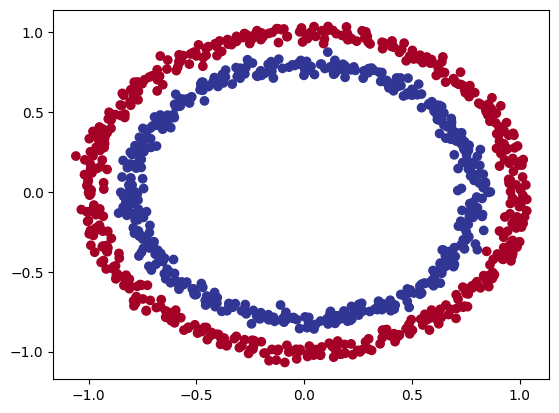

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

# Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
X_sample,X_sample.shape, y_sample

(array([0.75424625, 0.23148074]), (2,), np.int64(1))

# Turn Data into Tensors and Test splits

In [ ]:
import torch

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
#Split Data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data is test data
                                                    random_state=42)

# Building a model

We need to:
 1. Setup device agonist code
 2. Construct a model, by subclassing `nn.Module`
 3. Define a loss function and optimizer
 4. Create trainingand test loop

In [ ]:
import torch
from torch import nn

# agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [ ]:
# Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #self.layer_1 = nn.Linear(in_features=2, out_features=5) #takes 2 features and upscale to 5 features
        #self.layer_2 = nn.Linear(in_features=5, out_features=1) # take 5 featrs from first layer and outputs 1

        self.two_linear = nn.Sequential(
          nn.Linear(in_features=2, out_features=5),
          nn.Linear(in_features=5, out_features=1)
        ).to(device)
    def forward(self, x):
      #return self.layer_2(self.layer_1(x)) # x -> layer1 -> layer 2
      return self.two_linear(x)


model_0 = CircleModelV0()
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True)

In [ ]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True)

In [ ]:
model_0.state_dict()

OrderedDict([('two_linear.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('two_linear.0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('two_linear.1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('two_linear.1.bias', tensor([-0.2060], device='cuda:0'))])

In [ ]:
# make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
untrained_preds = model_0(X_test.to(device))
len(untrained_preds)
print(untrained_preds[:10])
print(y_test[:10])

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Setup Loss Function and Optimizer

For regression *MAE or MSE* is what we might want

For classification we might want to use *binary cross entropy* or *categorial cross entropy*

`torch.nn.BECWithLogitsLoss` - our loss function

In [ ]:
# Setup the Loss Function
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activation function build-in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [14]:
# Calculate accuracy

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc


# Train model

`raw logits -> prediction probabilities -> prediction labels`

In [ ]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

In [ ]:
# Use the sigmoid activation function on our model logits to turn them into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

For our prediction probability we perform range-style rouding on them

`y_pred_probs`>= 0.5, y = 1

`y_pred_probs`<= 0.5, y = 0

In [ ]:
# find the predicted label
y_preds = torch.round(y_pred_probs)

# in full: logits -> pred probs -> pred labels
y_pred_labels= torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


# Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train.squeeze())
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train.unsqueeze(dim=1)) # nn.BCEWithLogitsLoss expects rawlogits as input

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test.squeeze())
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits.squeeze(),
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)


if epoch % 100 == 0:
  print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")






In [ ]:
X_train.device


device(type='cuda', index=0)

In [26]:
import requests
from pathlib import Path

# Download helper function from Learn Pytorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

NameError: name 'model_0' is not defined

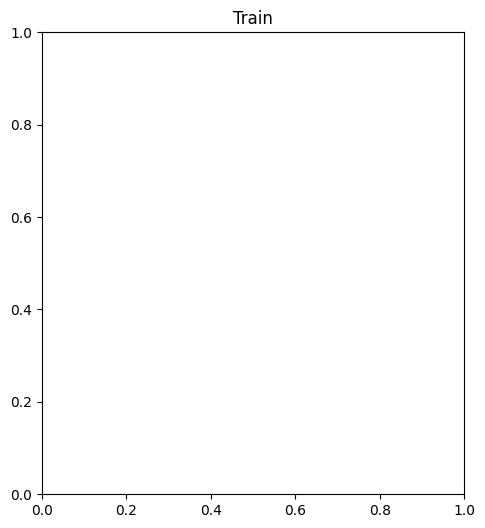

In [27]:
# Plotdecision boundary ofthe model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Improving a model

* Add more layers
* Add more hidden units - from 5 hidden units to 10 hidden UnitChoices
* Fit for longer
* Change the activation function
* Change the learning random_integers
* Change the optimization function

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)


  def forward(self, x):
    #z = self.layer1(x)
    #z = self.layer2(z)
    #z= self.layer3(z)
    return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

In [ ]:
next(model_1.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802]], device='cuda:0', requires_grad=True)

In [ ]:
torch.manual_seed(42)

epochs = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # Forward Pass
  y_logits = model_1(X_train.squeeze())
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train.unsqueeze(dim=1))

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test.to(device).squeeze())
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits.squeeze(),
                        y_test)

    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:5f}%")


Epoch: 0 | Loss: 0.69396 | Acc: 40000.00000% | Test Loss: 0.69261 | Test Acc: 10000.000000%
Epoch: 100 | Loss: 0.69369 | Acc: 40000.00000% | Test Loss: 0.69269 | Test Acc: 10000.000000%
Epoch: 200 | Loss: 0.69351 | Acc: 40000.00000% | Test Loss: 0.69282 | Test Acc: 10000.000000%
Epoch: 300 | Loss: 0.69339 | Acc: 40000.00000% | Test Loss: 0.69295 | Test Acc: 10000.000000%
Epoch: 400 | Loss: 0.69329 | Acc: 40000.00000% | Test Loss: 0.69309 | Test Acc: 10000.000000%
Epoch: 500 | Loss: 0.69322 | Acc: 40000.00000% | Test Loss: 0.69322 | Test Acc: 10000.000000%
Epoch: 600 | Loss: 0.69317 | Acc: 40000.00000% | Test Loss: 0.69335 | Test Acc: 10000.000000%
Epoch: 700 | Loss: 0.69313 | Acc: 40000.00000% | Test Loss: 0.69347 | Test Acc: 10000.000000%
Epoch: 800 | Loss: 0.69309 | Acc: 40000.00000% | Test Loss: 0.69358 | Test Acc: 10000.000000%
Epoch: 900 | Loss: 0.69307 | Acc: 40000.00000% | Test Loss: 0.69368 | Test Acc: 10000.000000%


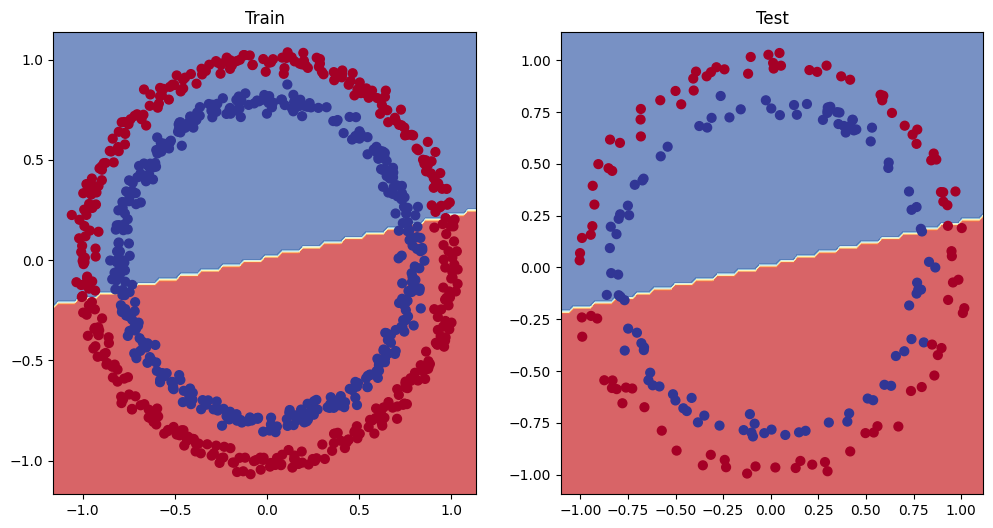

In [ ]:
# Plotdecision boundary ofthe model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# Preparing our data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to testout a smaller problem

In [ ]:
# Create some data (same as notebook 01)
weight =0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias



In [ ]:
# Train and Test split

train_split = int(0.8 * len(X_regression))

X_train, y_train = X_regression[:train_split], y_regression[:train_split]
X_test, y_test = X_regression[train_split:], y_regression[train_split:]

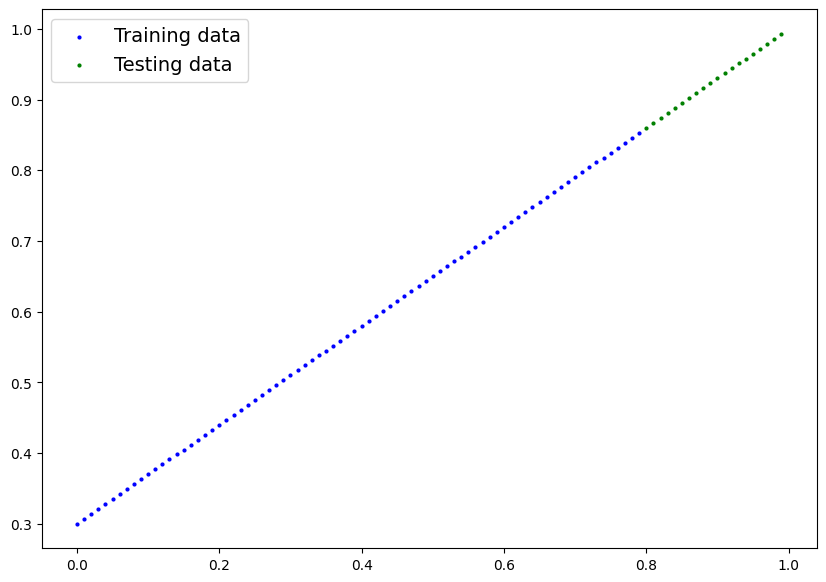

In [ ]:
plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test)

# Adjust `model_1` to fit a straight line

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and Optimizer

loss_fn= nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)




In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test= X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_2.train()

  y_pred = model_2(X_train)
  loss = loss_fn(y_pred,
                 y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")



Epoch: 0 | Loss: 0.75986 | Test Loss: 0.69378
Epoch: 10 | Loss: 0.40240 | Test Loss: 0.69378
Epoch: 20 | Loss: 0.06007 | Test Loss: 0.69378
Epoch: 30 | Loss: 0.01559 | Test Loss: 0.69378
Epoch: 40 | Loss: 0.03092 | Test Loss: 0.69378
Epoch: 50 | Loss: 0.03196 | Test Loss: 0.69378
Epoch: 60 | Loss: 0.03192 | Test Loss: 0.69378
Epoch: 70 | Loss: 0.03081 | Test Loss: 0.69378
Epoch: 80 | Loss: 0.03077 | Test Loss: 0.69378
Epoch: 90 | Loss: 0.02967 | Test Loss: 0.69378
Epoch: 100 | Loss: 0.02858 | Test Loss: 0.69378
Epoch: 110 | Loss: 0.02962 | Test Loss: 0.69378
Epoch: 120 | Loss: 0.02748 | Test Loss: 0.69378
Epoch: 130 | Loss: 0.02852 | Test Loss: 0.69378
Epoch: 140 | Loss: 0.02850 | Test Loss: 0.69378
Epoch: 150 | Loss: 0.02744 | Test Loss: 0.69378
Epoch: 160 | Loss: 0.02638 | Test Loss: 0.69378
Epoch: 170 | Loss: 0.02637 | Test Loss: 0.69378
Epoch: 180 | Loss: 0.02532 | Test Loss: 0.69378
Epoch: 190 | Loss: 0.02636 | Test Loss: 0.69378
Epoch: 200 | Loss: 0.02533 | Test Loss: 0.69378
Epo

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

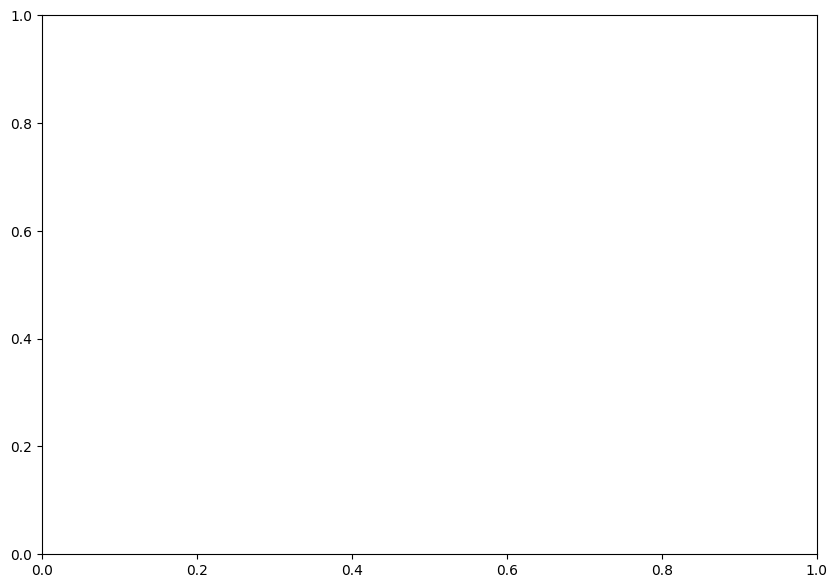

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test)


plot_predictions(train_data=X_train,
                 train_labels=y_train,
                 test_data=X_test,
                 test_labels=y_test,
                 predictions=y_preds)

# The missing piece: non-linearity

# Recreating non-linear data

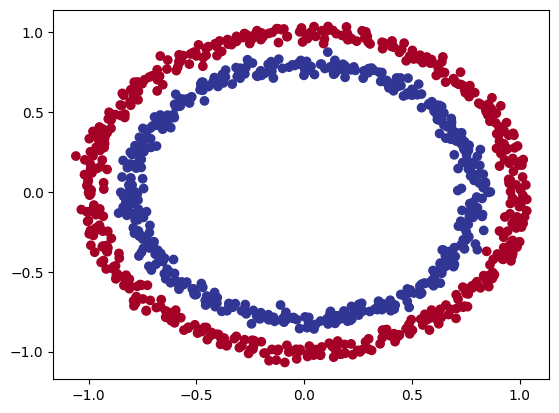

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

sample = 1000

X, y = make_circles(sample,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# Convert data to tensor and train and test split
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_3 = CircleModelV2().to(device)
model_3


CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.manual_seed(42)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)
epochs  = 1000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  optimizer.zero_grad()
  loss = loss_fn(y_logits,
                 y_train)

  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits.squeeze(),
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc}")

X_train: torch.Size([800, 2])
X_test: torch.Size([200, 2])
y_train: torch.Size([800])
y_test: torch.Size([200])
Epoch: 0 | Loss: 0.64945 | Acc: 66.62500% | Test Loss: 0.65917 | Test Acc: 60.0
Epoch: 10 | Loss: 0.64753 | Acc: 66.87500% | Test Loss: 0.65775 | Test Acc: 59.0
Epoch: 20 | Loss: 0.64550 | Acc: 66.87500% | Test Loss: 0.65623 | Test Acc: 59.0
Epoch: 30 | Loss: 0.64338 | Acc: 66.87500% | Test Loss: 0.65463 | Test Acc: 59.0
Epoch: 40 | Loss: 0.64111 | Acc: 67.25000% | Test Loss: 0.65290 | Test Acc: 59.0
Epoch: 50 | Loss: 0.63874 | Acc: 67.25000% | Test Loss: 0.65107 | Test Acc: 59.5
Epoch: 60 | Loss: 0.63624 | Acc: 67.12500% | Test Loss: 0.64911 | Test Acc: 60.5
Epoch: 70 | Loss: 0.63358 | Acc: 67.37500% | Test Loss: 0.64700 | Test Acc: 60.5
Epoch: 80 | Loss: 0.63077 | Acc: 68.00000% | Test Loss: 0.64471 | Test Acc: 60.5
Epoch: 90 | Loss: 0.62780 | Acc: 68.75000% | Test Loss: 0.64222 | Test Acc: 60.5
Epoch: 100 | Loss: 0.62461 | Acc: 68.87500% | Test Loss: 0.63948 | Test Acc: 62

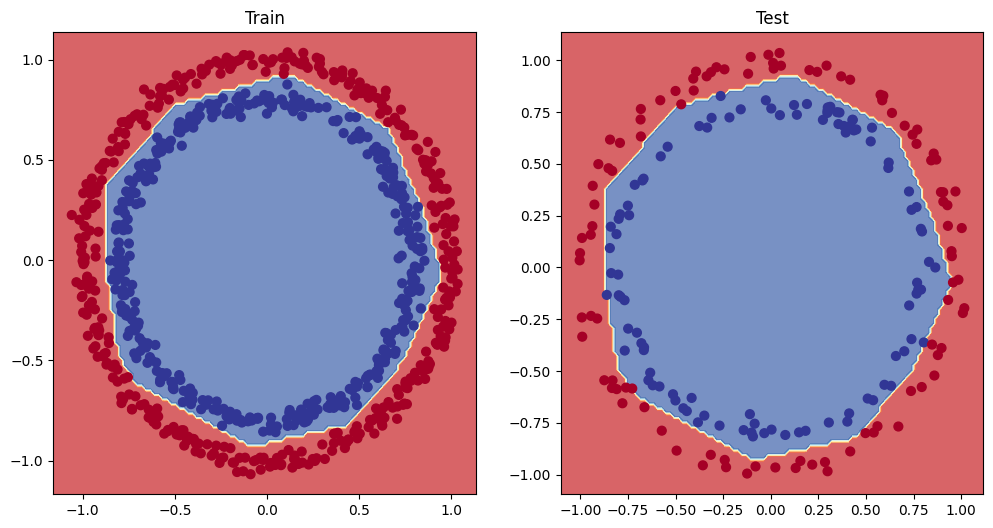

In [ ]:
# Plotdecision boundary ofthe model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)



# Replecating non-linear activation functions

Neural Networks - we give it the tools to discover patterns in data and it tries to figure out the patterns on its own

In [ ]:
# Create a Tensor

A = torch.arange(-10.0, 10.0, 1.0, dtype=torch.float32)



A.dtype


torch.float32

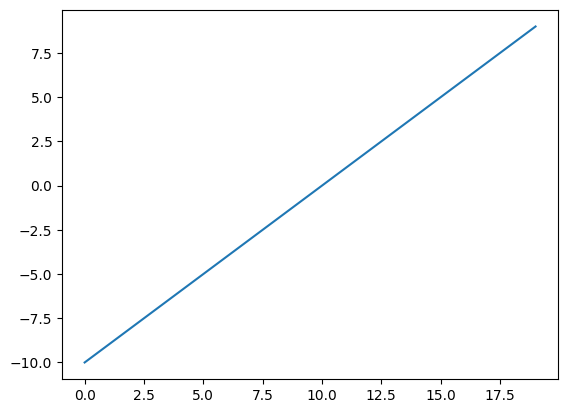

In [ ]:
plt.plot(A)

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.zeros_like(x), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

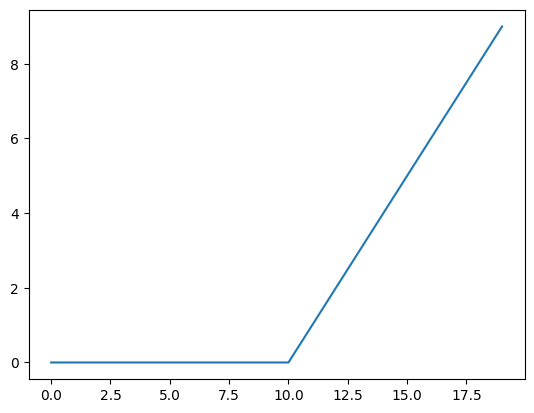

In [ ]:
plt.plot(relu(A))

In [ ]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.exp(-x))

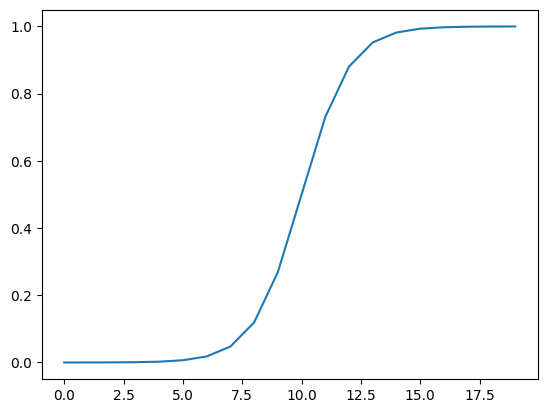

In [ ]:
plt.plot(sigmoid(A))

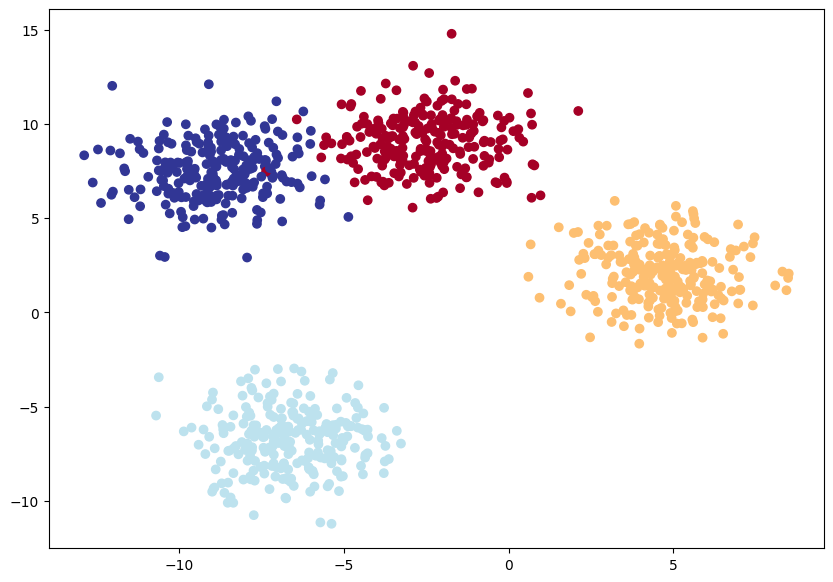

In [5]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),

    )

  def forward(self, x):
    return self.linear_layer_stack(x)


blob_model_1 = BlobModel(input_features=2,
                         output_features=4,
                         hidden_units=8).to(device)
blob_model_1


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

# Create a loss function and an optimier

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=blob_model_1.parameters(),
                            lr=0.1)



In order to evaluate and train and test our model, we need to convert our  model outputs(logtis) to prediction probabilities and then to

In [9]:
# Let's get some raw outputs of our model (logits)
blob_model_1.eval()
with torch.inference_mode():
  y_logits = blob_model_1(X_blob_test.to(device))


y_logits[:10]

tensor([[ 0.2177, -0.1676, -0.1381,  0.2028],
        [ 0.5704, -0.3664, -0.4747,  2.0939],
        [ 0.3172, -1.0248, -0.7582,  1.4802],
        [ 0.2084, -0.1768, -0.1175,  0.2133],
        [ 0.4035, -0.1654, -0.2289,  1.2853],
        [ 0.5833, -0.4194, -0.6200,  2.5455],
        [ 0.2511, -1.0012, -0.6249,  1.3298],
        [ 0.4847, -0.1859, -0.2305,  1.4005],
        [ 0.3001, -1.2619, -1.0268,  1.9337],
        [ 0.4652, -0.1927, -0.2192,  1.3517]], device='cuda:0')

In [10]:
# Conver model logits outputs to prediction provabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10], y_logits[:10]

(tensor([[0.2971, 0.2021, 0.2081, 0.2927],
         [0.1579, 0.0619, 0.0555, 0.7246],
         [0.2082, 0.0544, 0.0710, 0.6663],
         [0.2935, 0.1997, 0.2119, 0.2949],
         [0.2216, 0.1255, 0.1177, 0.5352],
         [0.1139, 0.0418, 0.0342, 0.8102],
         [0.2154, 0.0616, 0.0897, 0.6334],
         [0.2223, 0.1137, 0.1087, 0.5554],
         [0.1516, 0.0318, 0.0402, 0.7764],
         [0.2248, 0.1164, 0.1134, 0.5454]], device='cuda:0'),
 tensor([[ 0.2177, -0.1676, -0.1381,  0.2028],
         [ 0.5704, -0.3664, -0.4747,  2.0939],
         [ 0.3172, -1.0248, -0.7582,  1.4802],
         [ 0.2084, -0.1768, -0.1175,  0.2133],
         [ 0.4035, -0.1654, -0.2289,  1.2853],
         [ 0.5833, -0.4194, -0.6200,  2.5455],
         [ 0.2511, -1.0012, -0.6249,  1.3298],
         [ 0.4847, -0.1859, -0.2305,  1.4005],
         [ 0.3001, -1.2619, -1.0268,  1.9337],
         [ 0.4652, -0.1927, -0.2192,  1.3517]], device='cuda:0'))

In [11]:
# Convertour model prediction probabilities to prediction labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
        3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
        3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')

In [12]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

# Create a training loop and testing loop for a multi-class PyTorch model

In [15]:
epochs = 100
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  blob_model_1.train()

  y_logits = blob_model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,
              y_blob_train.type(torch.LongTensor).to(device))
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  blob_model_1.eval()
  with torch.inference_mode():
    test_logits = blob_model_1(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,
                     y_blob_test.type(torch.LongTensor).to(device))

    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.5f}%")




Epoch: 0 | Loss: 1.51467 | Acc: 24.12500% | Test Loss: 1.19891 | Test Acc: 28.50000%
Epoch: 10 | Loss: 0.64823 | Acc: 94.37500% | Test Loss: 0.56401 | Test Acc: 98.00000%
Epoch: 20 | Loss: 0.49343 | Acc: 76.75000% | Test Loss: 0.39066 | Test Acc: 81.50000%
Epoch: 30 | Loss: 0.13457 | Acc: 98.87500% | Test Loss: 0.12331 | Test Acc: 99.50000%
Epoch: 40 | Loss: 0.08446 | Acc: 99.12500% | Test Loss: 0.07586 | Test Acc: 99.50000%
Epoch: 50 | Loss: 0.06233 | Acc: 99.12500% | Test Loss: 0.05450 | Test Acc: 99.50000%
Epoch: 60 | Loss: 0.05041 | Acc: 99.25000% | Test Loss: 0.04293 | Test Acc: 99.50000%
Epoch: 70 | Loss: 0.04409 | Acc: 99.12500% | Test Loss: 0.03657 | Test Acc: 99.50000%
Epoch: 80 | Loss: 0.04005 | Acc: 99.12500% | Test Loss: 0.03240 | Test Acc: 99.50000%
Epoch: 90 | Loss: 0.03726 | Acc: 99.12500% | Test Loss: 0.02943 | Test Acc: 99.50000%


In [16]:
y_blob_test.shape, test_pred.shape

(torch.Size([200]), torch.Size([200]))

In [17]:
# Make prediction
blob_model_1.eval()

with torch.inference_mode():
  y_logits = blob_model_1(X_blob_test.to(device))


y_logits[:10]


tensor([[-1.7458,  5.7804, -2.3227, -0.7975],
        [ 0.7174, -6.5585, -0.4440,  5.6856],
        [-7.3180, -3.9553,  9.5508,  3.8850],
        [-1.3654,  4.5512, -1.7595, -0.7027],
        [ 5.7767, -1.2881, -4.7998,  0.8788],
        [ 0.4347, -7.9585, -0.3062,  7.0236],
        [-6.1016, -3.3424,  8.1366,  3.1916],
        [ 6.1706, -2.1323, -4.7875,  1.1137],
        [-9.5694, -5.0858, 12.1036,  5.1828],
        [ 5.9724, -1.8234, -4.6696,  0.9767]], device='cuda:0')

In [18]:
# Go from ligits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]



tensor([[5.3761e-04, 9.9777e-01, 3.0193e-04, 1.3876e-03],
        [6.8925e-03, 4.7701e-06, 2.1579e-03, 9.9094e-01],
        [4.7041e-08, 1.3579e-06, 9.9655e-01, 3.4503e-03],
        [2.6682e-03, 9.9036e-01, 1.7991e-03, 5.1764e-03],
        [9.9173e-01, 8.4765e-04, 2.5300e-05, 7.4009e-03],
        [1.3728e-03, 3.1079e-07, 6.5435e-04, 9.9797e-01],
        [6.5061e-07, 1.0271e-05, 9.9292e-01, 7.0682e-03],
        [9.9341e-01, 2.4618e-04, 1.7302e-05, 6.3234e-03],
        [3.8647e-10, 3.4221e-08, 9.9901e-01, 9.8606e-04],
        [9.9285e-01, 4.0853e-04, 2.3721e-05, 6.7185e-03]], device='cuda:0')

In [19]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [20]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.], device='cuda:0')

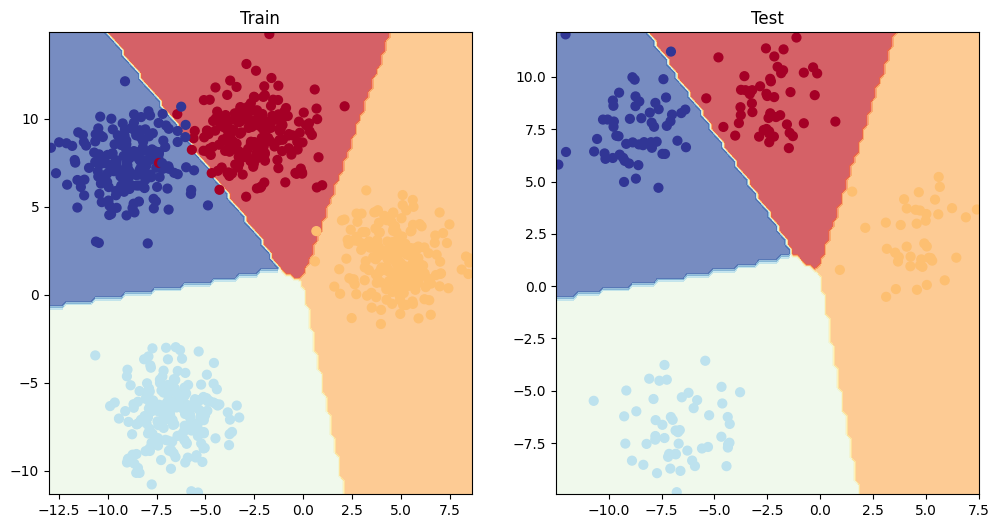

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(blob_model_1, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(blob_model_1, X_blob_test, y_blob_test)

# A few more classification metrics (to evalutate our classification model)

* Accuracy - out of 100 sample, how many are right?
* Precision
* Recall
* F1 Score
* Confusion Metrics
* Classification Report

In [22]:
!pip install torchmetrics

In [24]:
from torchmetrics import Accuracy

# Setupmetric
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

AttributeError: 'MulticlassAccuracy' object has no attribute 'shape'